For the 158 known EBs in K2 Campaign 0, we injected a fake planet using Emma's code. This is an investigation of what we found. 

#Gather all data for exploration 

In [171]:
%matplotlib inline
import ketu, sys, pickle, shutil, os
from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as pl
from astropy.io import fits, ascii
import remove_EB as remEB
import swarced as sw
from __future__ import unicode_literals
import matplotlib as mpl
mpl.rcParams['text.usetex']=True
mpl.rcParams['text.latex.unicode']=True

In [3]:
path = "/k2_data/c0_known_EB_lc/"
contents = os.listdir(path)
contents = np.array([fn for fn in contents if ("_injected_clip.result" in fn)])
epicid = np.array([fn.split("-")[0][4:] for fn in contents],dtype=np.int32)
ref = ascii.read("/k2_data/c0_EB")
refrows = np.array([list(ref['KIC/EPIC']).index(ind) for ind in epicid])
refsub = ref[refrows]
eb_period = np.array([ref[i]['period'] for i in refrows])

Get all of the input parameters from the injected planets.

In [4]:
inj_center, inj_period, inj_rpbyrs, inj_tdepth, inj_tctime, inj_prad, inj_srad, inj_smass, inj_impact = [],[], [], [], [], [], [], [], []
for fn in contents:
    hdulist = fits.open(path + fn.split(".")[0] + ".fits")
    head = hdulist[3].header
    inj_period += [head['PERIOD']]
    inj_rpbyrs += [head['RRATIO']]
    inj_tdepth += [head['TDEPTH']]
    inj_tctime += [head['TCTIME']+hdulist[1].header['BJDREFI']]
    inj_prad += [head['PRADRJ']]
    inj_srad += [head['SRADRS']]
    inj_smass += [head['MSTAR']]
    inj_impact += [head['IMPACT']]
    inj_center += [hdulist[3].data['center'][0] +hdulist[1].header['BJDREFI']]
    hdulist.close()

Everythin is converted to numpy arrays. 

In [5]:
inj_period, inj_rpbyrs, inj_tdepth=np.array(inj_period), np.array(inj_rpbyrs), np.array(inj_tdepth)                                                   
inj_tctime, inj_prad, inj_srad = np.array(inj_tctime), np.array(inj_prad), np.array(inj_srad)
inj_smass, inj_impact =np.array(inj_smass), np.array(inj_impact)
inj_center = np.array(inj_center)
contents, epicid = np.array(contents), np.array(epicid)

Find the recovered period

In [6]:
recovered_period = []
for fn in contents:
    with open(path + fn,'r')as f:
        result = pickle.load(f)
        recovered_period += [result['peaks'][0]['period']]
recovered_period = np.array(recovered_period)

Ratio of recovery period to expected period

In [43]:
success = recovered_period - inj_period

#Overview 

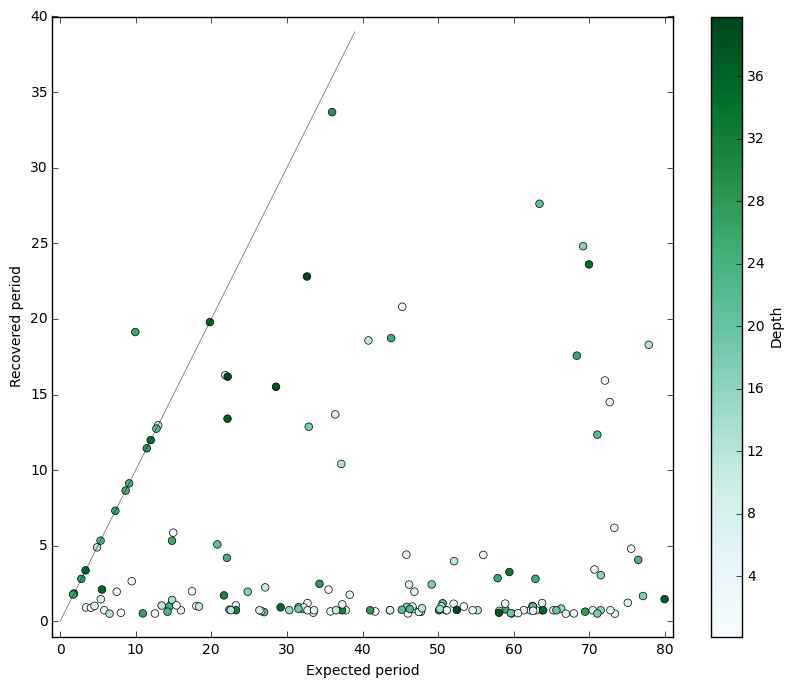

In [8]:
fig = pl.figure(figsize=(10,8))
pl.scatter(inj_period, recovered_period, c=inj_tdepth,cmap='BuGn', lw=0.5, s=30)
pl.colorbar(label= "Depth")
#pl.scatter(expected_period, second_recover, c='red',s=30,lw=0.5)
pl.plot(range(40), 'k',lw=0.3 )
pl.ylabel("Recovered period")
pl.xlabel("Expected period")
pl.xlim(-1,81)
pl.ylim(-1,40)

pl.show()

As you can see above, most of the planets were not properly detected. Only those on the plotted line match. 

In [44]:
sum(abs(success) <= 0.1) #success is recovered_period/inj_period

14

So only 14 of the original 158 injections matched our expectation (matched meaning they were within $\pm 0.1$ days of the period! You can see that many of the low injected planet depth (those with low $R_{*}/R_{p}$) have a recovered period near 0. However, There are certainly some with decent depths that one would think would be recovered that aren't. 

#Successes! 

First, I just want to show what all the successes looked like:

In [45]:
mask = abs(success) < 0.1

In [52]:
contents_s, ref_s, epicid_s, eb_period_s = contents[mask], ref[mask], epicid[mask], eb_period[mask]
inj_period_s, inj_rpbyrs_s, inj_tdepth_s, inj_tctime_s = inj_period[mask], inj_rpbyrs[mask], inj_tdepth[mask], inj_tctime[mask] 
inj_prad_s, inj_srad_s, inj_smass_s, inj_impact_s = inj_prad[mask], inj_srad[mask], inj_smass[mask], inj_impact[mask]
success_s , recovered_period_s, inj_center_s= success[mask], recovered_period[mask], inj_center[mask]

In [47]:
len("REC_PERIOD")

10

In [48]:
print("{0:^9s} {1:^10s} {2:^10s}".format("EPIC_ID","INJ_PERIOD","REC_PERIOD"))
for i in range(len(epicid_s)):
    print("{0:9d} {1:10.2f} {2:10.2f}".format(epicid_s[i],inj_period_s[i],recovered_period_s[i]))

 EPIC_ID  INJ_PERIOD REC_PERIOD
202091278       2.82       2.82
202064253       7.31       7.32
202071731      19.82      19.79
202060198       3.37       3.37
202073440       1.85       1.84
202062176      11.47      11.45
202071635       4.89       4.90
202126851      12.97      12.97
202086627      11.99      11.98
202093968       9.13       9.13
202071828      12.75      12.75
202073442       8.67       8.65
202088387       1.72       1.78
202072430       5.36       5.34


Below you'll find the injected lightcurves with the EB not clipped and then the phased plot (phased on the injectd period) of the lightcurve with the EB clipped for all 14 successes.

1.8518518518518519

In [ ]:
def validate_eb(epicid, campaign, period, center, result_path):
    sw.plot_lc(epicid, campaign)
    sw.plot_periodogram(result_path)
    sw.plot_phase(epicid,campaign,period,center)

In [ ]:
def validate_planet(epicid, campaign, pperiod,ebperiod, pcenter,ebcenter, inpath="/k2_data/c0_known_EB_lc/"):
    sw.plot_lc(epicid, campaign, inpath=inpath, tail="_injected_clip",injected=True)
    #sw.plot_phase(epicid, campaign, ebperiod, ebcenter, inpath=inpath,tail="_injected")
    #sw.plot_phase(epicid, campaign, pperiod, inj_center_h[i], inpath=inpath,tail="_injected")
    sw.plot_phase(epicid, campaign, pperiod, inj_center_h[i], inpath=inpath,tail="_injected_clip")

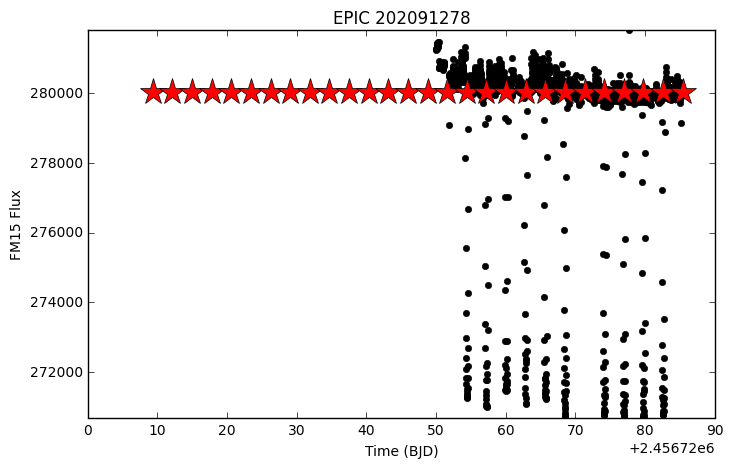

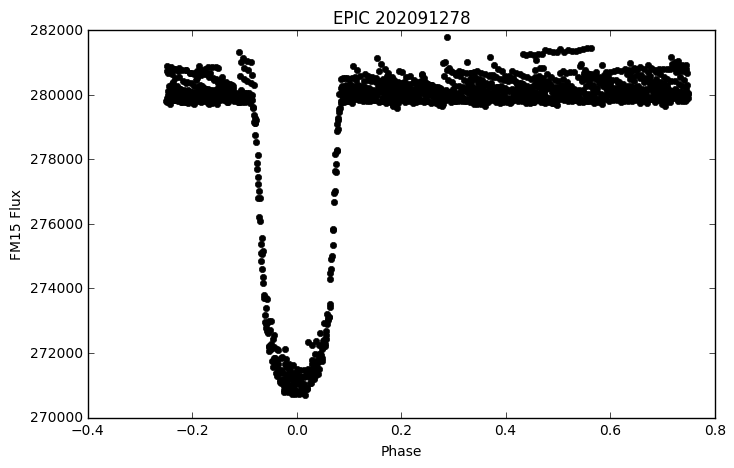

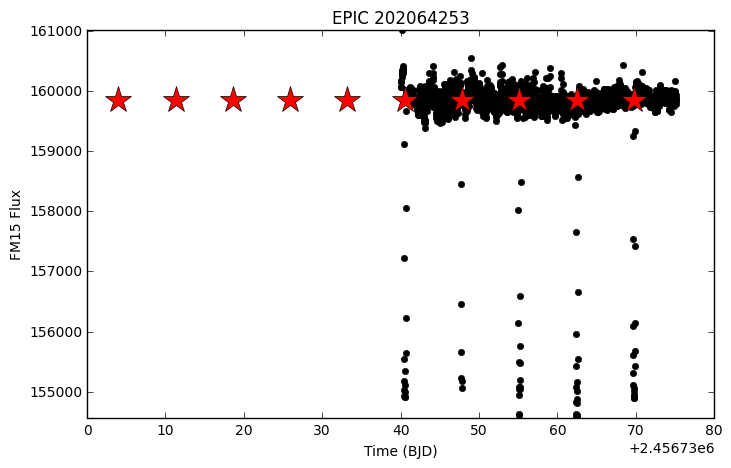

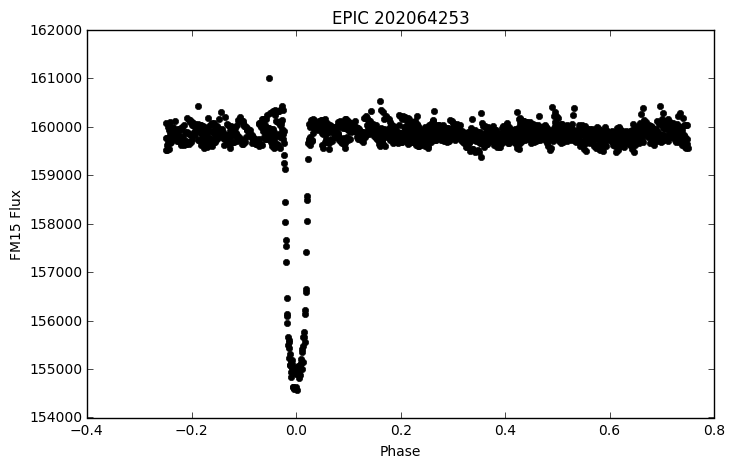

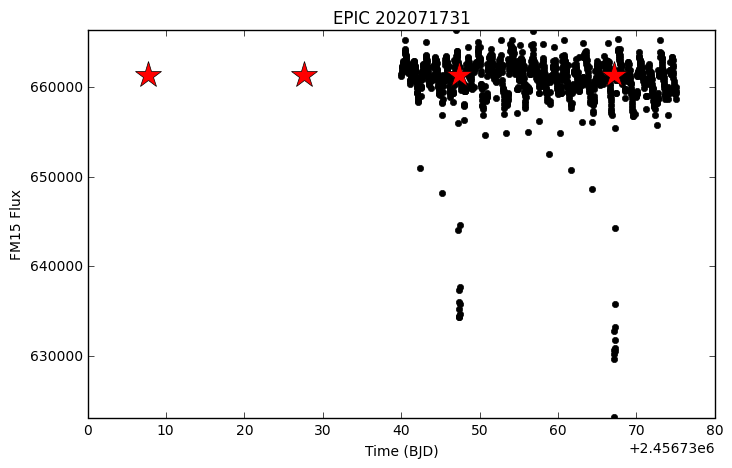

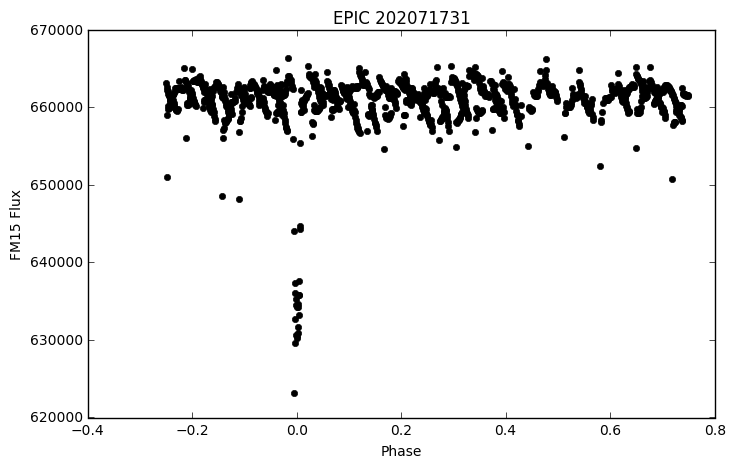

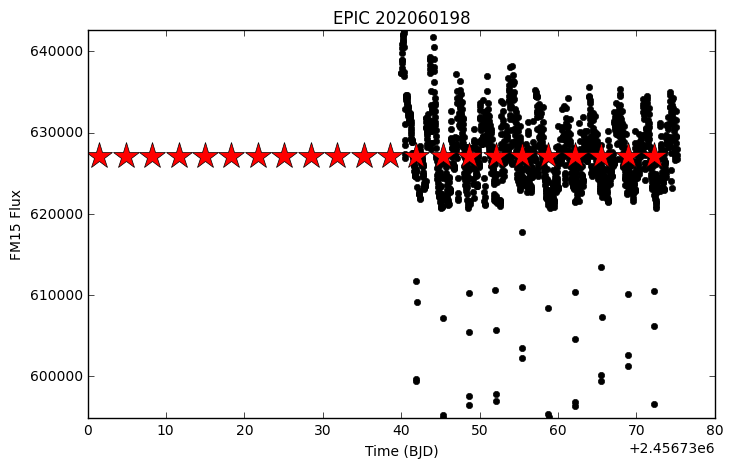

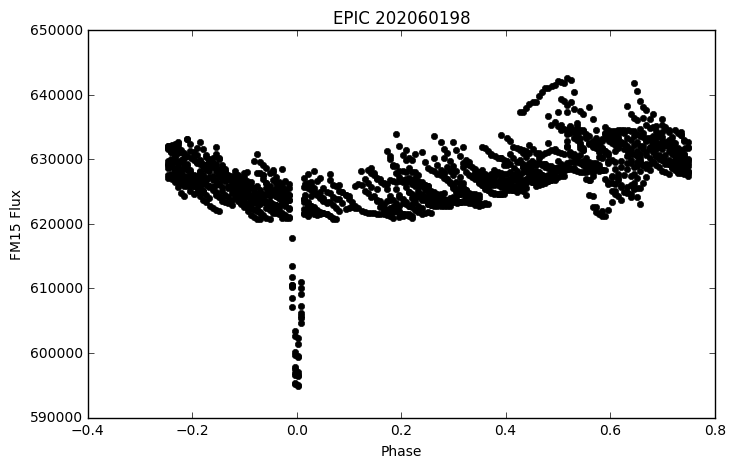

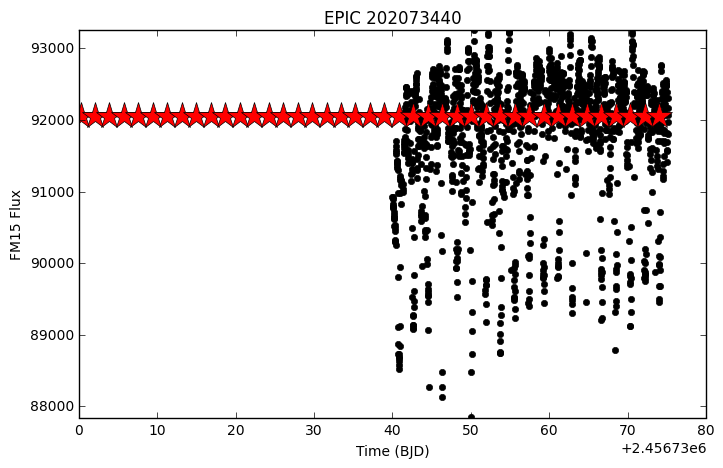

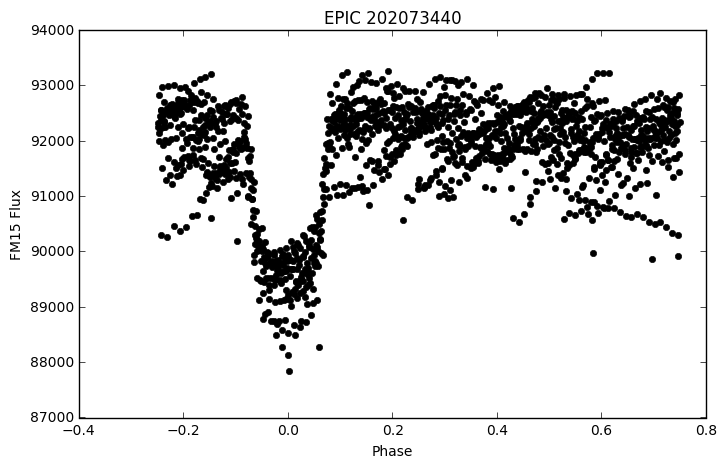

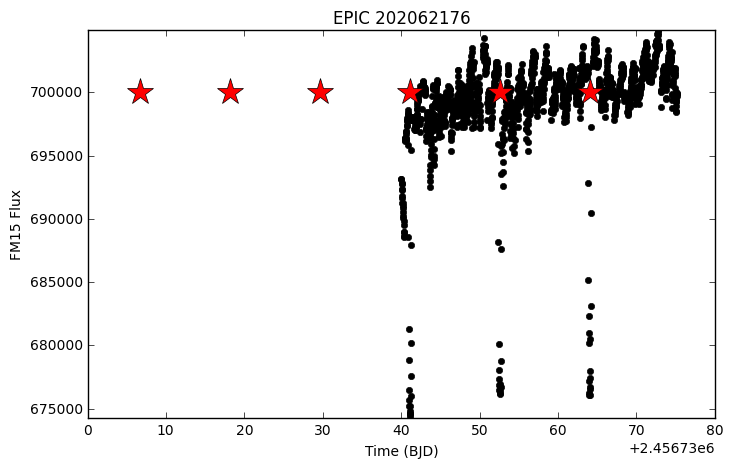

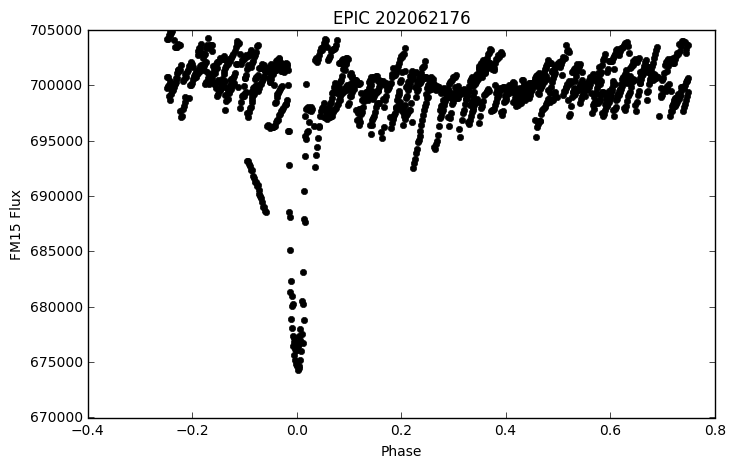

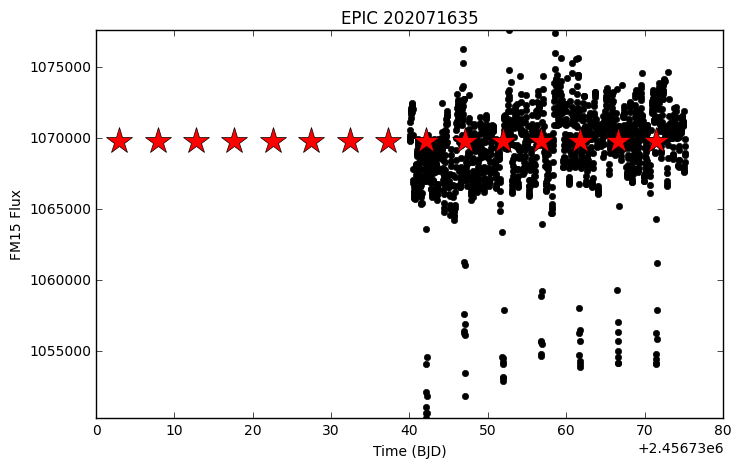

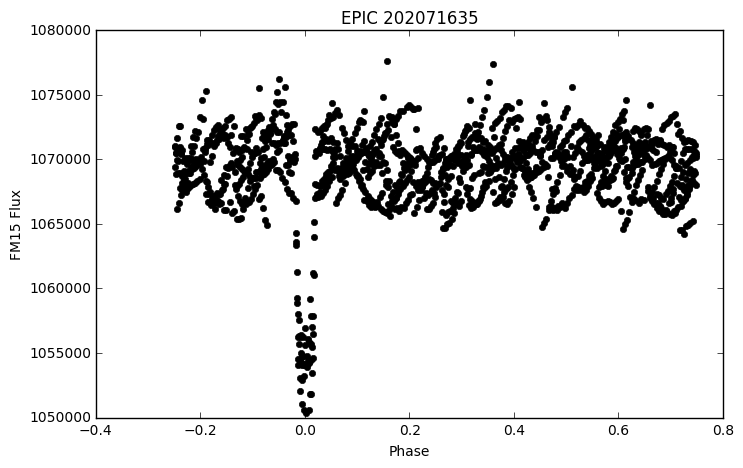

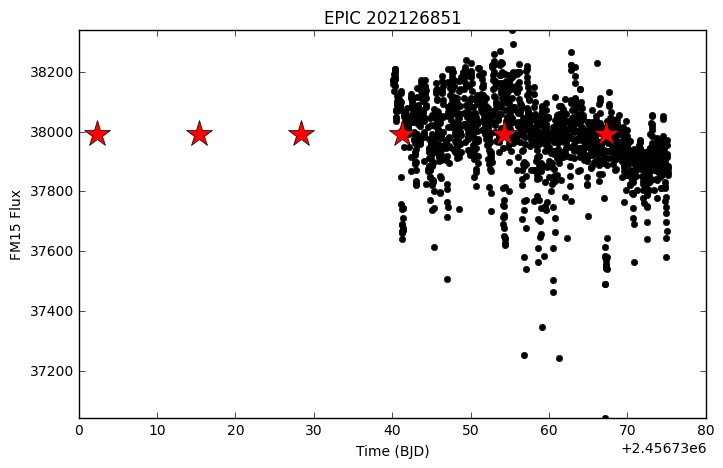

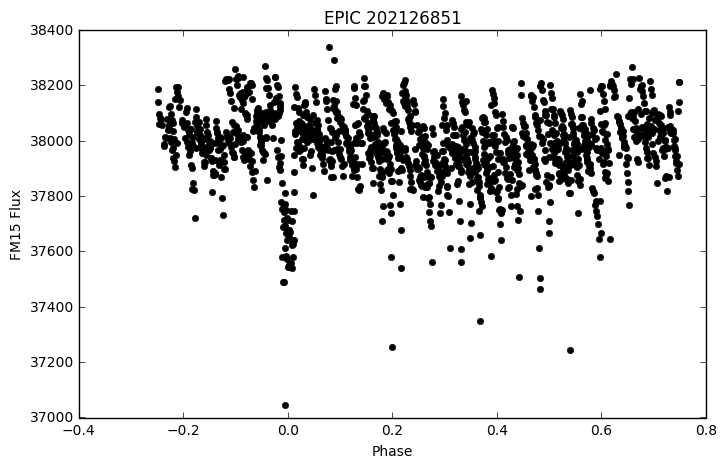

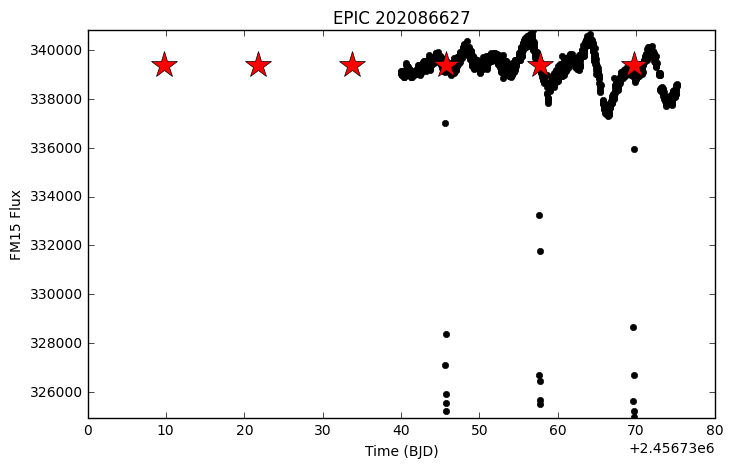

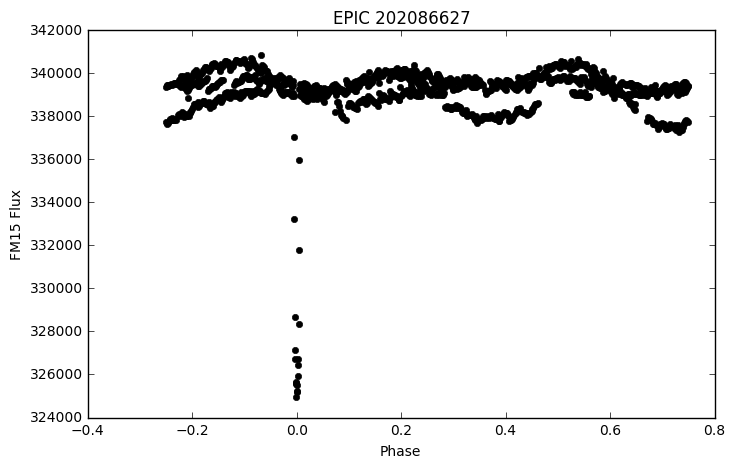

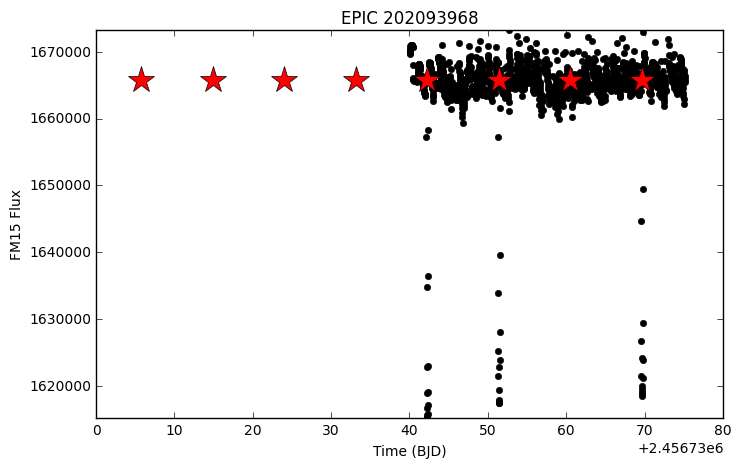

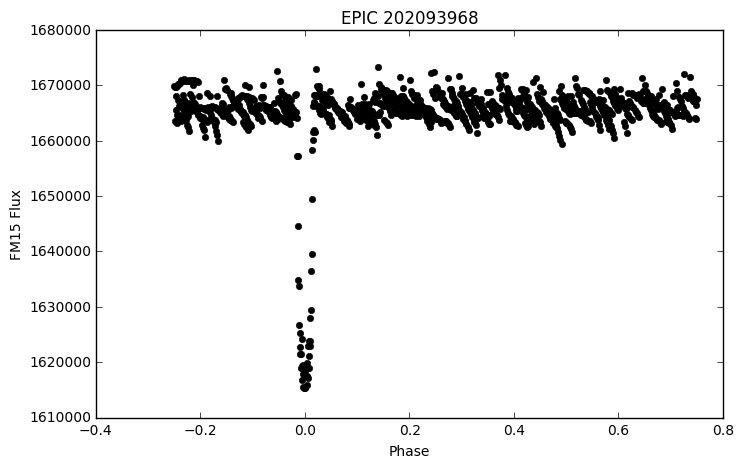

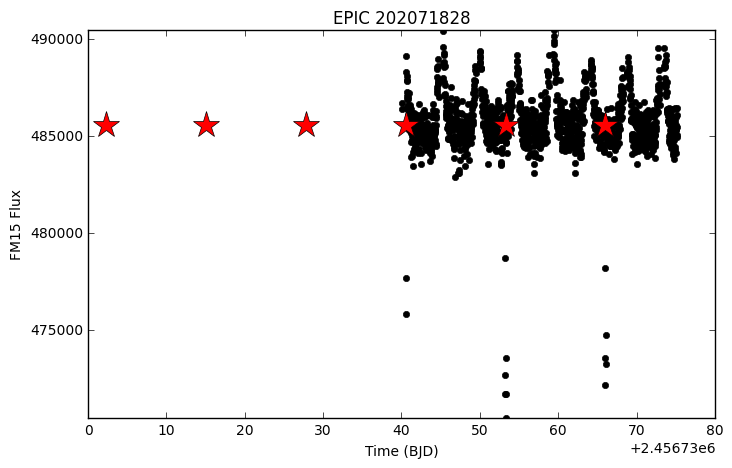

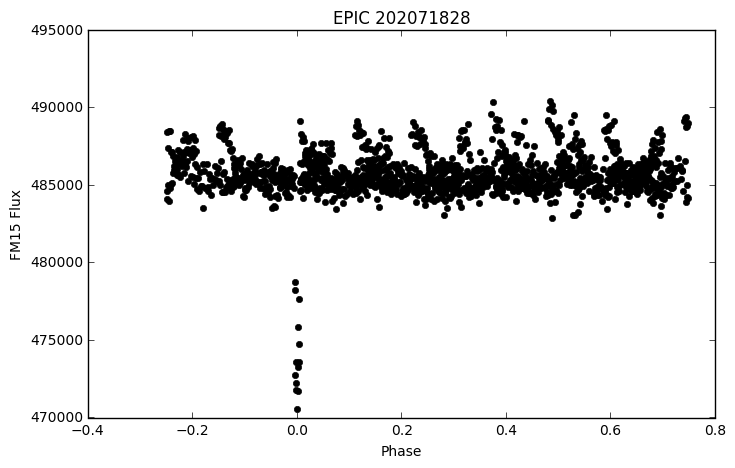

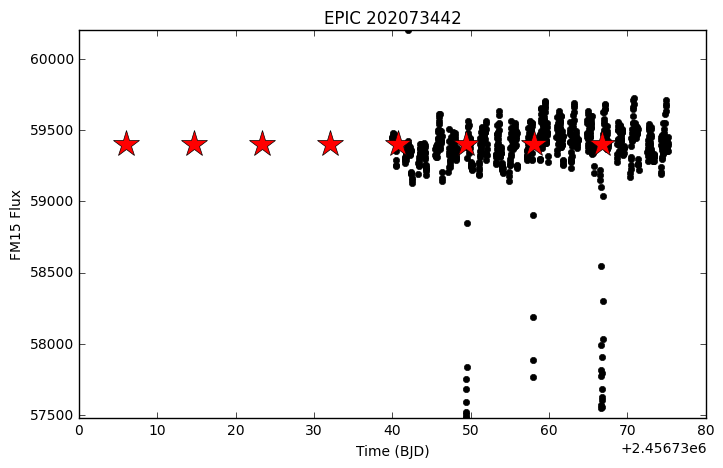

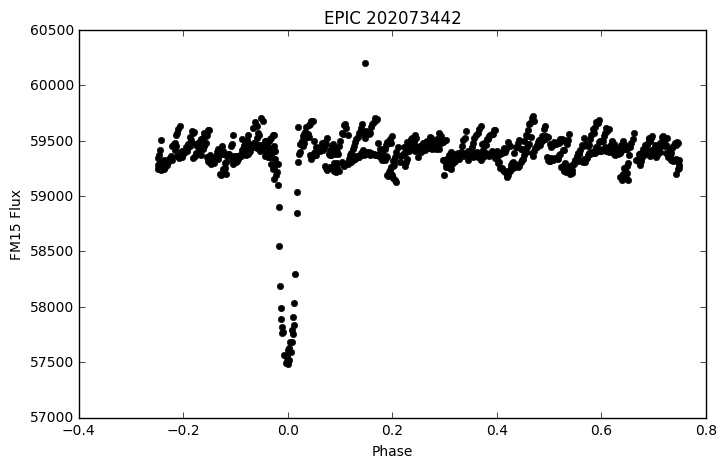

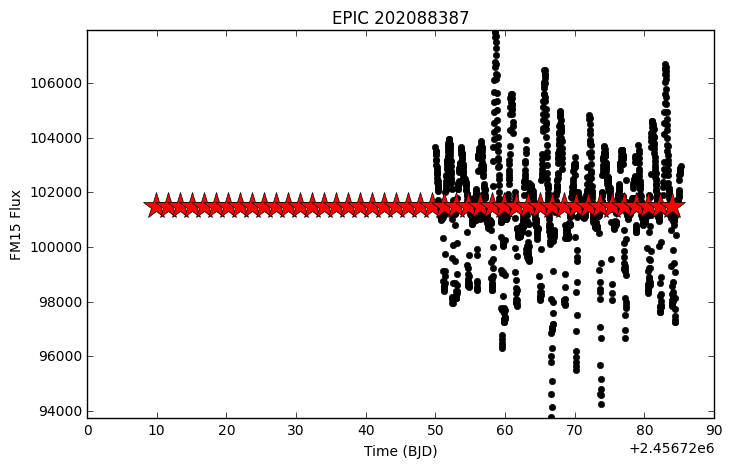

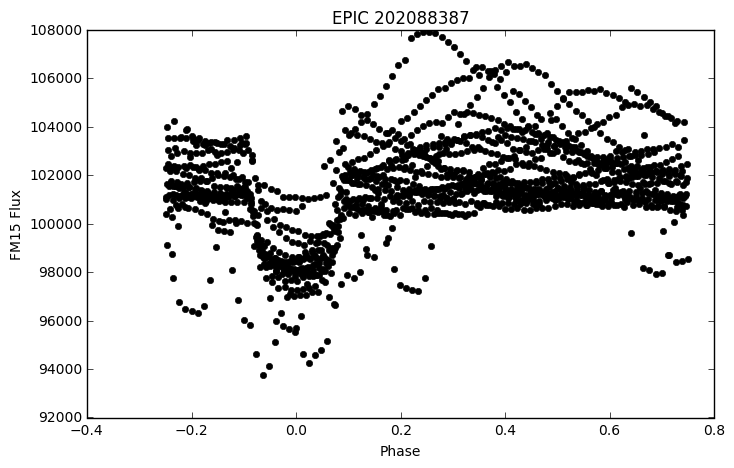

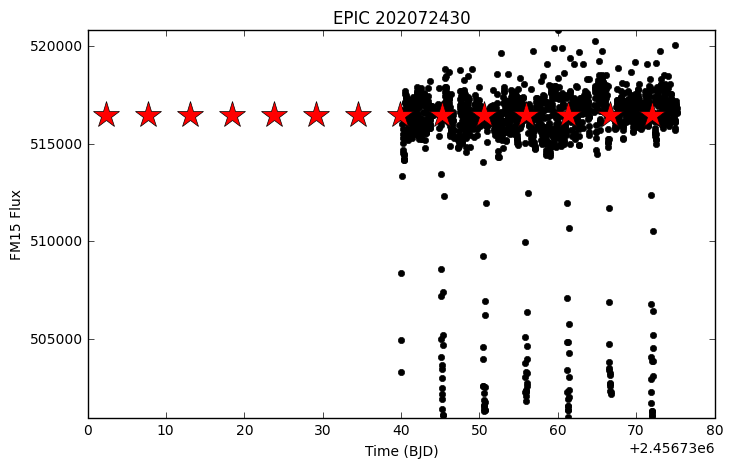

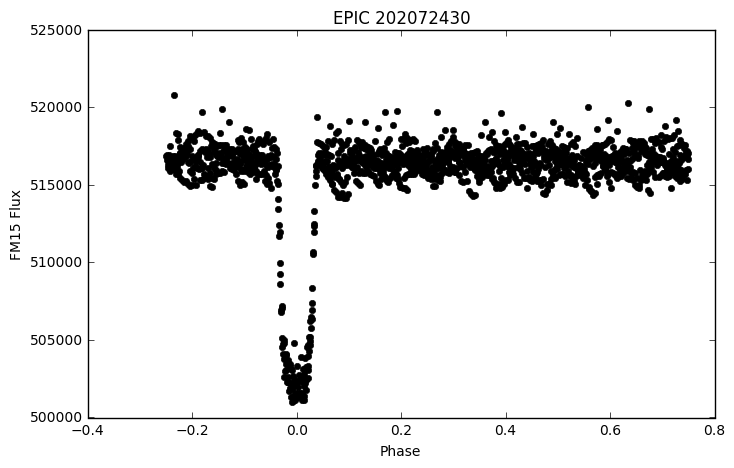

In [56]:
for i in range(len(epicid_s)):
    r = ref[refrows[i]]
    sw.plot_lc(epicid_s[i], 0,inpath="/k2_data/c0_known_EB_lc/",tail="_injected_clip",injected=True)
    #sw.plot_phase(epicid_s[i], 0,r['period'], r['bjd0'], inpath="/k2_data/c0_known_EB_lc/",tail="_injected")
    #sw.plot_phase(epicid_s[i], 0,inj_period_s[i], inj_center_s[i], inpath="/k2_data/c0_known_EB_lc/",tail="_injected")
    sw.plot_phase(epicid_s[i], 0,inj_period_s[i], inj_center_s[i], inpath="/k2_data/c0_known_EB_lc/",tail="_injected_clip")

#Low Lying Failures 

In the overview plot, you can see that many of the recovered periods formed a floor around zero. We'll explore the distribution of those now. 

In [67]:
mask = (abs(success) > 0.1) * (recovered_period < 1.5)

In [68]:
contents_s, ref_s, epicid_s, eb_period_s = contents[mask], ref[mask], epicid[mask], eb_period[mask]
inj_period_s, inj_rpbyrs_s, inj_tdepth_s, inj_tctime_s = inj_period[mask], inj_rpbyrs[mask], inj_tdepth[mask], inj_tctime[mask] 
inj_prad_s, inj_srad_s, inj_smass_s, inj_impact_s = inj_prad[mask], inj_srad[mask], inj_smass[mask], inj_impact[mask]
success_s , recovered_period_s, inj_center_s= success[mask], recovered_period[mask], inj_center[mask]

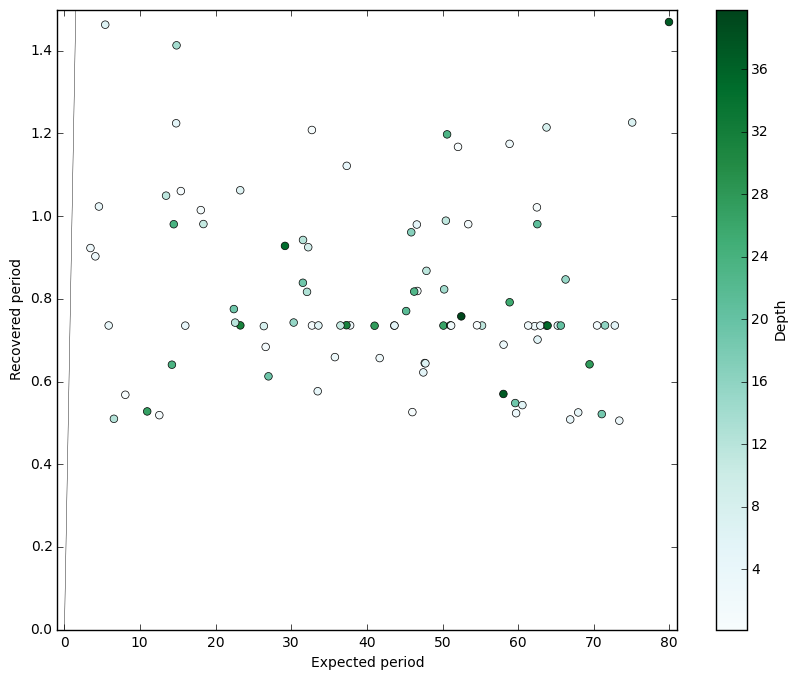

In [66]:
fig = pl.figure(figsize=(10,8))
pl.scatter(inj_period, recovered_period, c=inj_tdepth,cmap='BuGn', lw=0.5, s=30)
pl.colorbar(label= "Depth")
#pl.scatter(expected_period, second_recover, c='red',s=30,lw=0.5)
pl.plot(range(40), 'k',lw=0.3 )
pl.ylabel("Recovered period")
pl.xlabel("Expected period")
pl.xlim(-1,81)
pl.ylim(0,1.5)
pl.show()

Below you see a histogram of the injected period for this sample. As you could have gathered from before, this low recovered period happens regardless of the injected period.

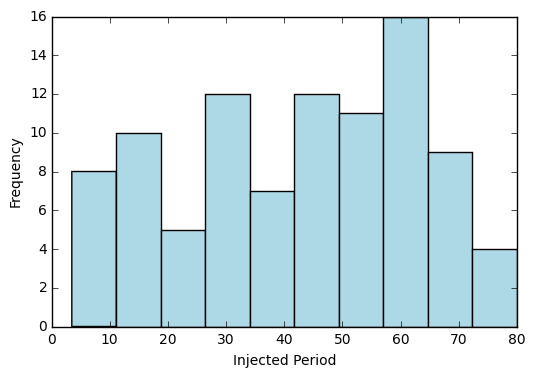

In [143]:
pl.figure()
pl.hist(inj_period_s,color="lightblue")
pl.xlabel("Injected Period")
pl.ylabel("Frequency")
pl.show()

As you can see below, this subset of failures (right) has a generally smaller transit depth than the entire sample. 

In [174]:
def compare_hist(main_variable, subset_variable, xlabel="",ylabel="Probability"):
    fig,axes = pl.subplots(1,2,sharey=True,figsize=(10,5))
    weights = np.ones_like(main_variable)/len(main_variable)
    axes[0].hist(main_variable,color="lightblue",weights=weights)
    weights = np.ones_like(subset_variable)/len(subset_variable)
    axes[1].hist(subset_variable,color="lightblue",weights=weights)

    #pl.ylim(0,0.1)
    fig.text(0.5, 0.04, xlabel, ha='center')
    fig.text(0.04, 0.5, ylabel, va='center', rotation='vertical')
    pl.show()

In [167]:
from matplotlib import rc

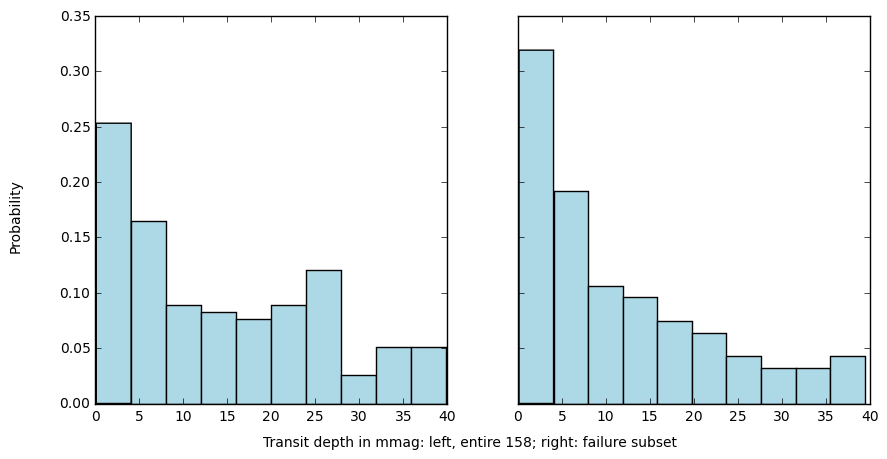

In [164]:
compare_hist(inj_tdepth, inj_tdepth_s,xlabel="Transit depth in mmag: left, entire 158; right: failure subset")

In [175]:
compare_hist(inj_rpbyrs, inj_rpbyrs_s,xlabel="$R_p/R_s$ left, entire 158; right: failure subset")

UnicodeDecodeError: 'ascii' codec can't decode byte 0xc5 in position 43: ordinal not in range(128)

(array([ 4.38659431,  3.37430331,  7.76089762,  6.4111763 ,  2.69944265,
         6.4111763 ,  5.06145497,  8.09832796,  3.71173365,  5.3988853 ]),
 array([ 0.01195298,  0.03070979,  0.04946659,  0.06822339,  0.08698019,
         0.10573699,  0.1244938 ,  0.1432506 ,  0.1620074 ,  0.1807642 ,
         0.199521  ]),
 <a list of 10 Patch objects>)

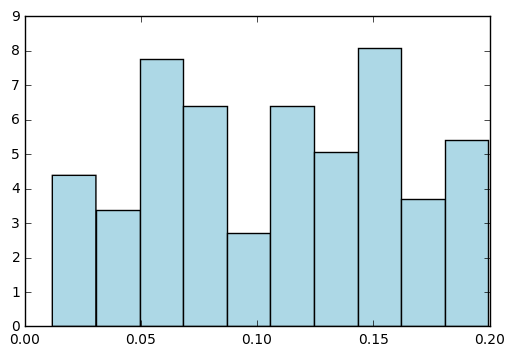

In [150]:
pl.hist(inj_rpbyrs,normed=True,color="lightblue")

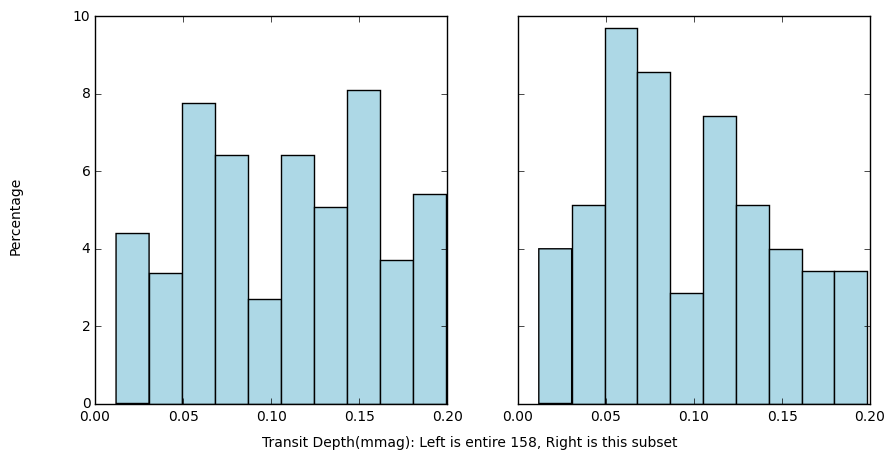

In [149]:
fig,axes = pl.subplots(1,2,sharey=True,figsize=(10,5))
axes[0].hist(inj_rpbyrs,normed=True,color="lightblue")
axes[1].hist(inj_rpbyrs_s,normed=True,color="lightblue")
#pl.ylim(0,0.1)
fig.text(0.5, 0.04, 'Transit Depth(mmag): Left is entire 158, Right is this subset', ha='center')
fig.text(0.04, 0.5, 'Percentage', va='center', rotation='vertical')
pl.show()